# Imports

In [1]:
import importlib.metadata
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns

from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.flux.hqflux import analyze_highest_quality_flux
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.plotting.cumulative import Cumulative

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.0


# Settings

In [2]:
SWIN_COL = "SW_IN_T1_2_1"
TA_COL = "TA_T1_2_1"
VPD_COL = "VPD_T1_2_1"
MGMT_VARS = [
    'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT',
    'TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', 'TIMESINCE_MGMT_SOWING_FOOTPRINT',
    'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']

# Random forest model settings
rf_settings = dict(
    verbose=1,    
    features_lag=[-1, -1], 
    features_lag_exclude_cols=MGMT_VARS,  # Management variables are not lagged
    include_timestamp_as_features=True,    
    add_continuous_record_number=False,
    sanitize_timestamp=True,
    n_estimators=5,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=5,
    n_jobs=-1)

# Load main data

In [3]:
SOURCEDIR = r"../60_MERGE_DATA_FLUXES"
FILENAME = r"61.1_FLUXES_M10_MGMT_L4.1_NEE-CUT165084_LE_H_FN2O-CUT50.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
maindf = load_parquet(filepath=FILEPATH)
locs = (maindf.index.year >= 2008) & (maindf.index.year <= 2010)
df = maindf[locs].copy()
df

Loaded .parquet file ..\60_MERGE_DATA_FLUXES\61.1_FLUXES_M10_MGMT_L4.1_NEE-CUT165084_LE_H_FN2O-CUT50.parquet (0.543 seconds). Detected time resolution of <30 * Minutes> / 30min 


,AIR_CP,AIR_DENSITY,AIR_MV,AIR_RHO_CP,AOA_METHOD,AXES_ROTATION_METHOD,...,SUM_L3.3_CUT_50_FN2O_L3.1_FLAGS,FLAG_L3.3_CUT_50_FN2O_L3.1_QCF,FN2O_L3.1_L3.3_CUT_50_QCF,FN2O_L3.1_L3.3_CUT_50_QCF0,FN2O_L3.1_L3.3_CUT_50_QCF_gfRF,FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2008-01-01 00:15:00,1007.65,1.26469,0.022862,1274.37,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 00:45:00,1007.71,1.26321,0.022888,1272.95,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 01:15:00,1007.69,1.26270,0.022897,1272.41,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 01:45:00,1007.64,1.26363,0.022881,1273.29,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 02:15:00,1007.63,1.26395,0.022875,1273.60,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31 21:45:00,1004.13,1.26391,0.022847,1269.13,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-31 22:15:00,1004.13,1.26368,0.022851,1268.90,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-31 22:45:00,1004.14,1.26362,0.022852,1268.85,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN


# Before

In [4]:
fluxes_nee = [c for c in df.columns if "gfRF" in c and not str(c).endswith("_ISFILLED") and str(c).startswith("NEE_")]
fluxes_nee

['NEE_L3.1_L3.3_CUT_16_QCF_gfRF',
 'NEE_L3.1_L3.3_CUT_50_QCF_gfRF',
 'NEE_L3.1_L3.3_CUT_84_QCF_gfRF']

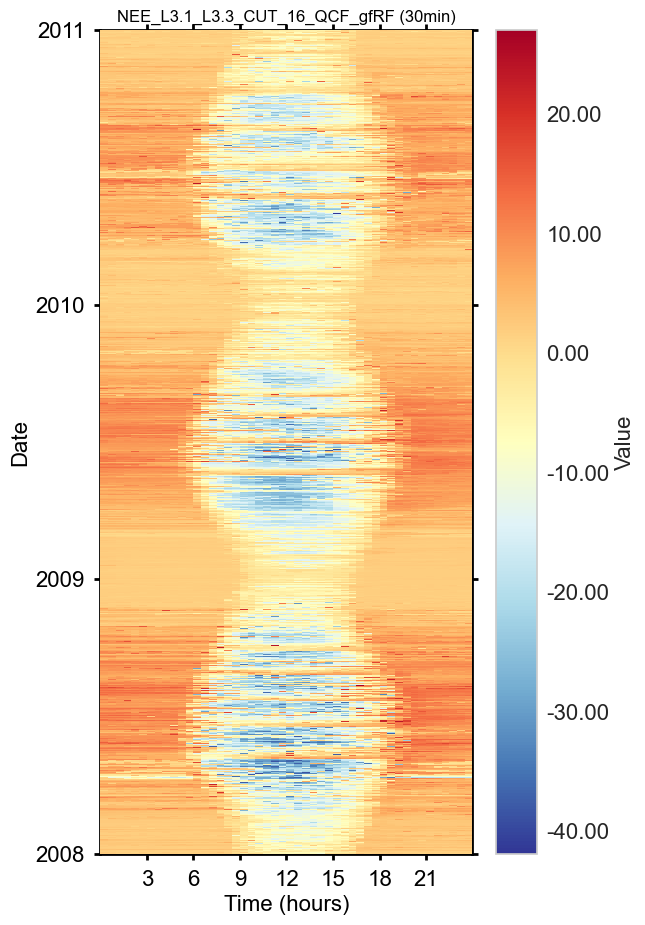

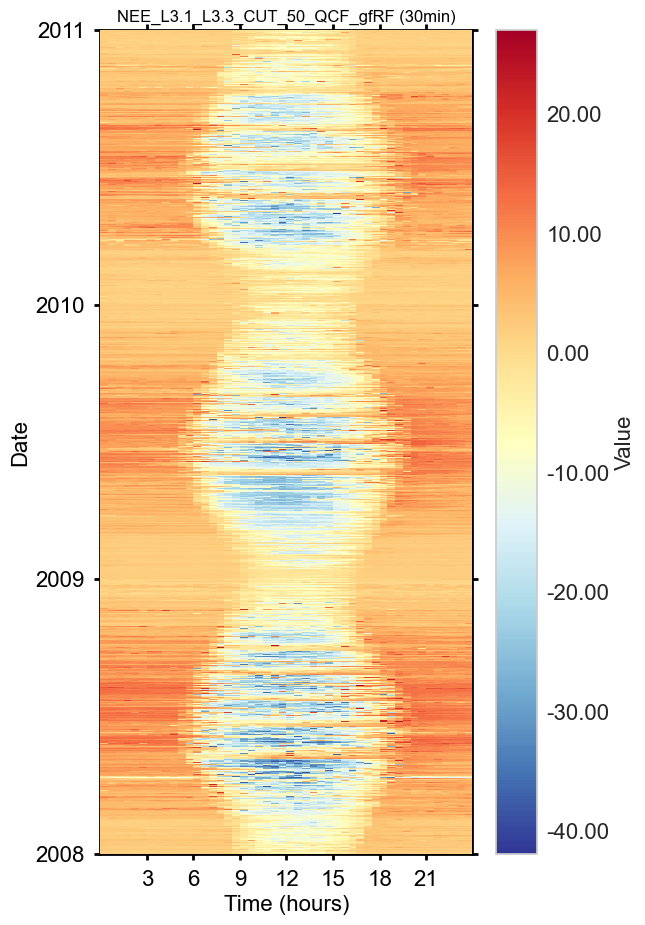

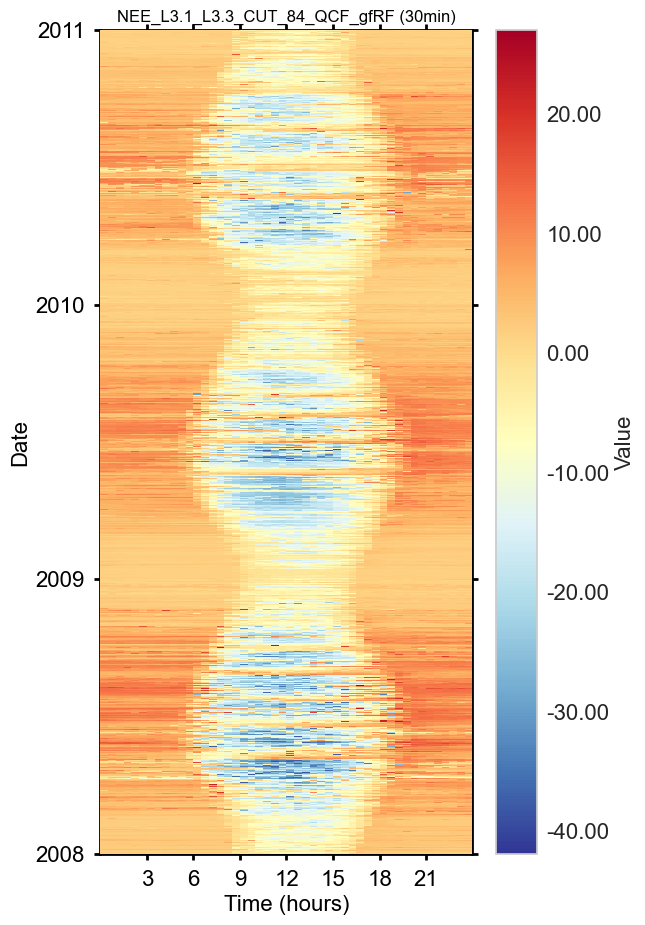

In [5]:
for f in fluxes_nee:
    HeatmapDateTime(series=df[f]).plot()

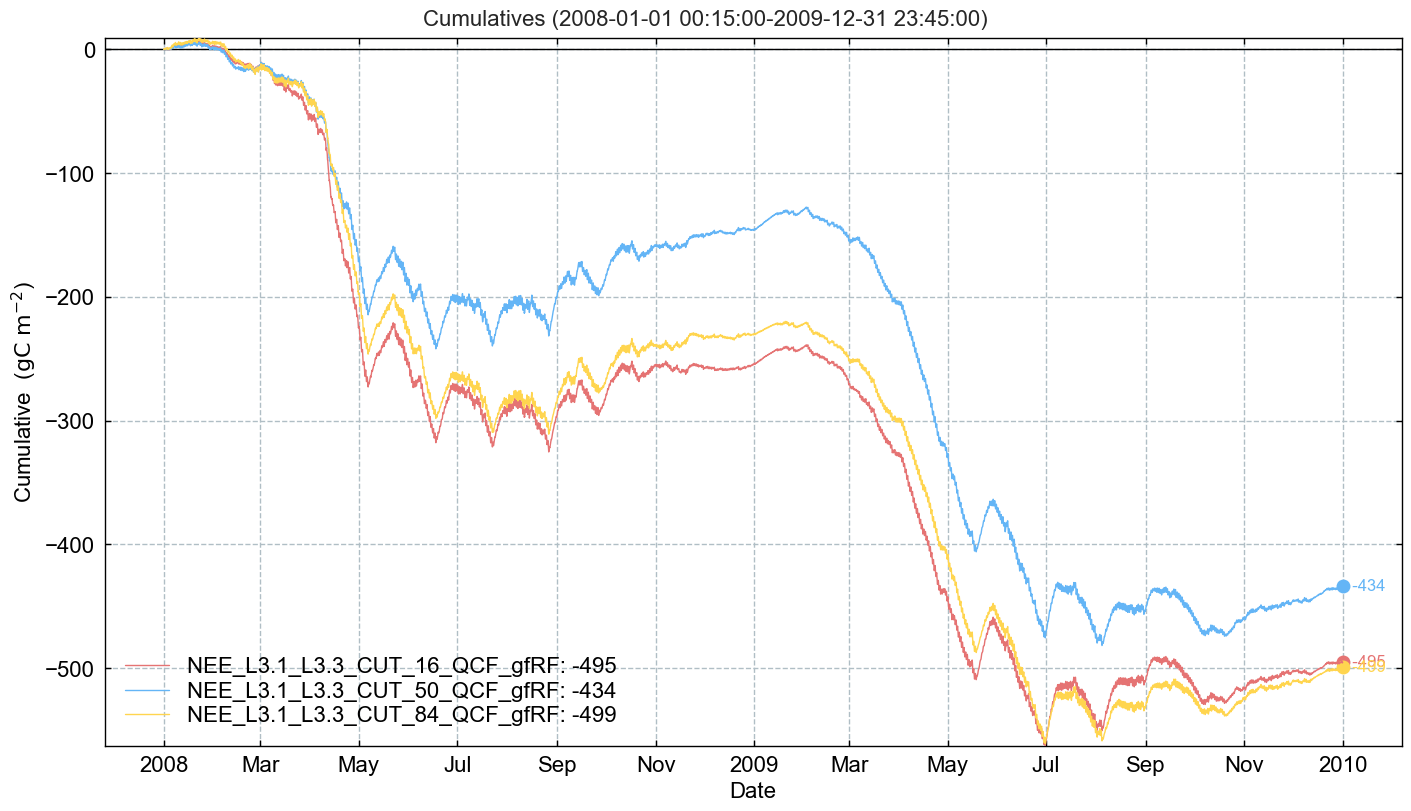

In [6]:
plotdf = df[fluxes_nee].copy()
locs = (plotdf.index.year >= 2008) & (plotdf.index.year <= 2009)
plotdf = plotdf[locs].copy()
plotdf = plotdf.multiply(0.02161926)
Cumulative(df=plotdf, units=r'($\mathrm{gC\ m^{-2}}$)').plot()

In [10]:
cut16 = df['NEE_L3.1_L3.3_CUT_16_QCF_gfRF'].copy()
cut50 = df['NEE_L3.1_L3.3_CUT_84_QCF_gfRF'].copy()
diff = cut50.sub(cut16)
diff.name = "DIFF"

<Axes: xlabel='TIMESTAMP_MIDDLE'>

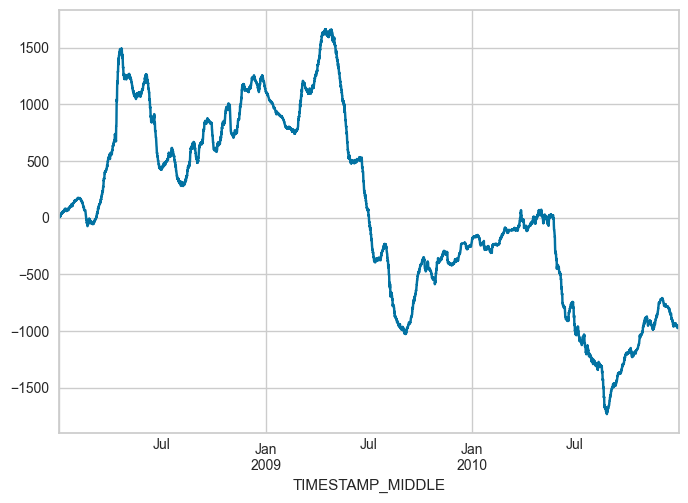

In [11]:
diff.cumsum().plot()

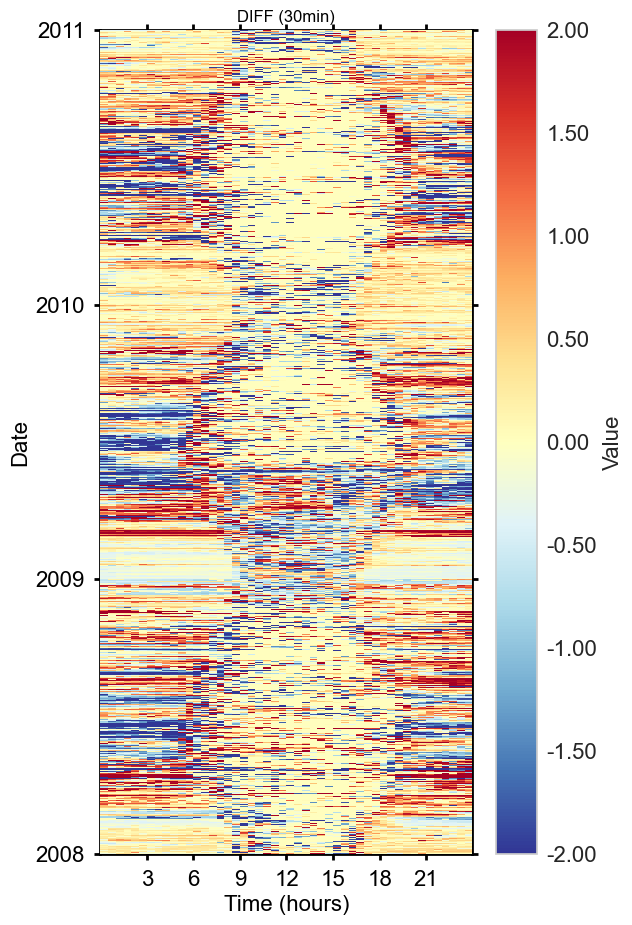

In [12]:
HeatmapDateTime(series=diff, vmin=-2, vmax=2).plot()

# Remove fluxes

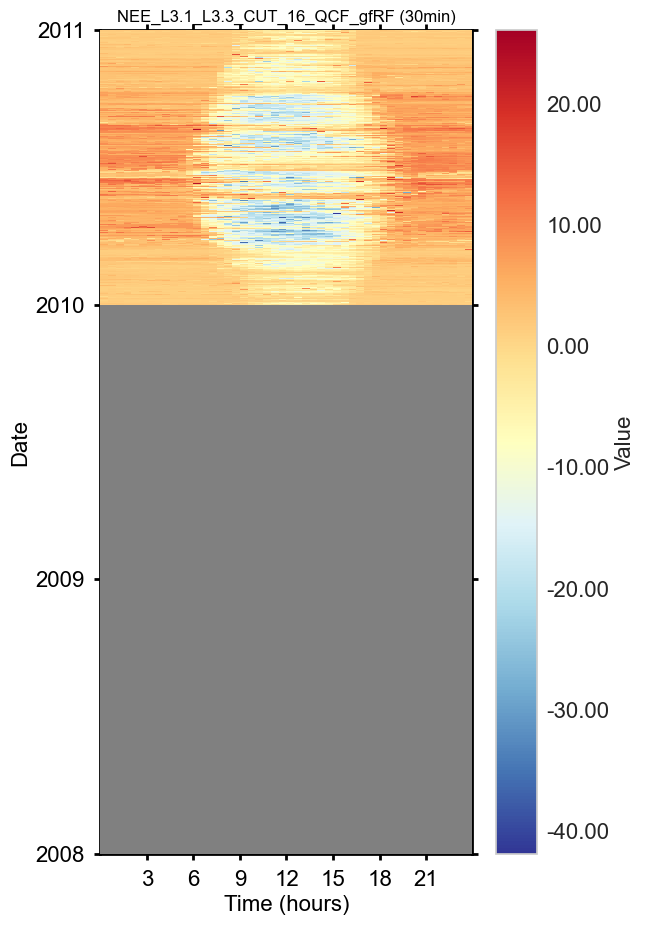

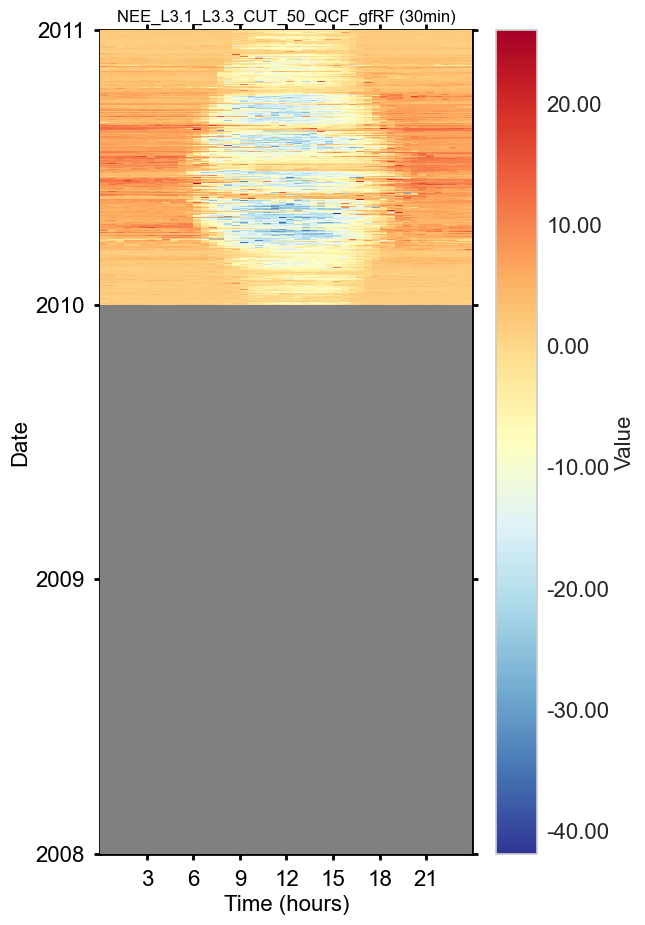

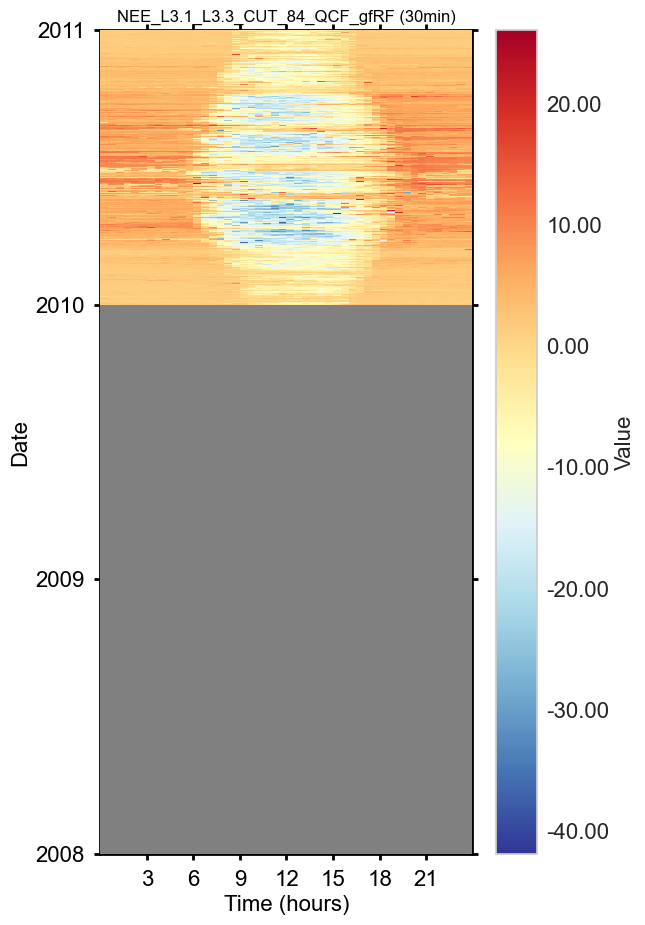

In [13]:
loc = (df.index.year >= 2008) & (df.index.year <= 2009)
for f in fluxes_nee:
    df.loc[loc, f] = np.nan
    HeatmapDateTime(series=df[f]).plot()

# years = [2008, 2009]
# for f in fluxes_nee:
#     for yr in years:     
#         for f in fluxes_nee:
#             flagname = f"FLAG_{f}_ISFILLED"
#             # loc = (df.index.year == yr) & (df[flagname] > 0)        
#             # df.loc[loc, f] = np.nan
#             loc = (df.index.year == yr)
#             df.loc[loc, f] = np.nan

# Gap-filling empty years



Starting gap-filling for
NEE_L3.1_L3.3_CUT_16_QCF_gfRF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['SW_IN_T1_2_1', 'TA_T1_2_1', 'VPD_T1_2_1'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['NEE_L3.1_L3.3_CUT_16_QCF_gfRF', 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', 'TIMESINCE_MGMT_SOWING_FOOTPRINT', 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to 

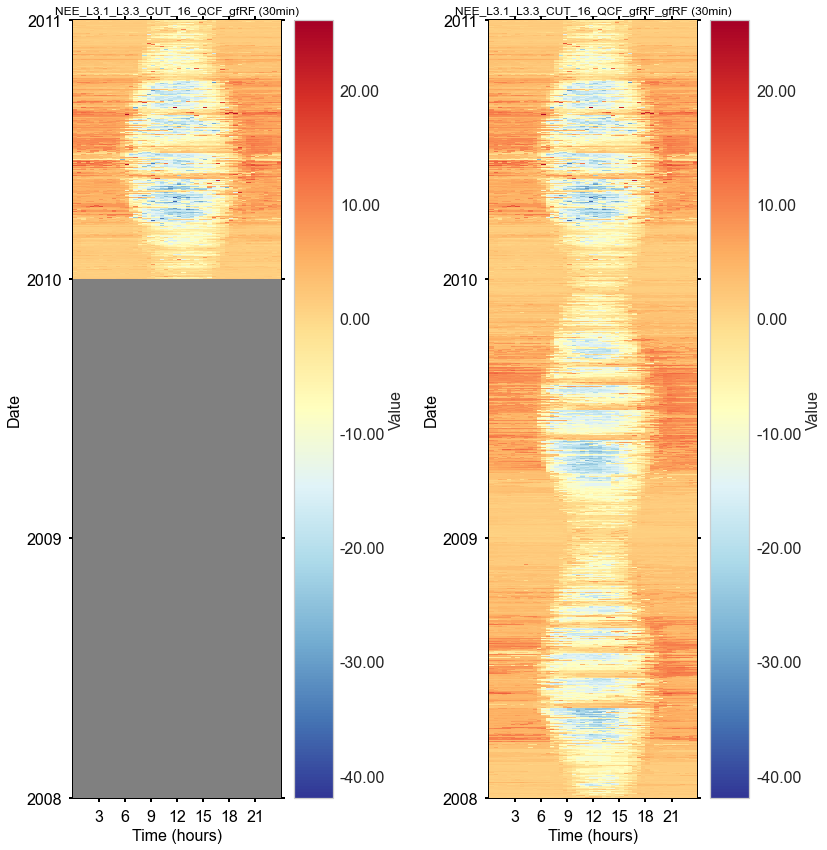

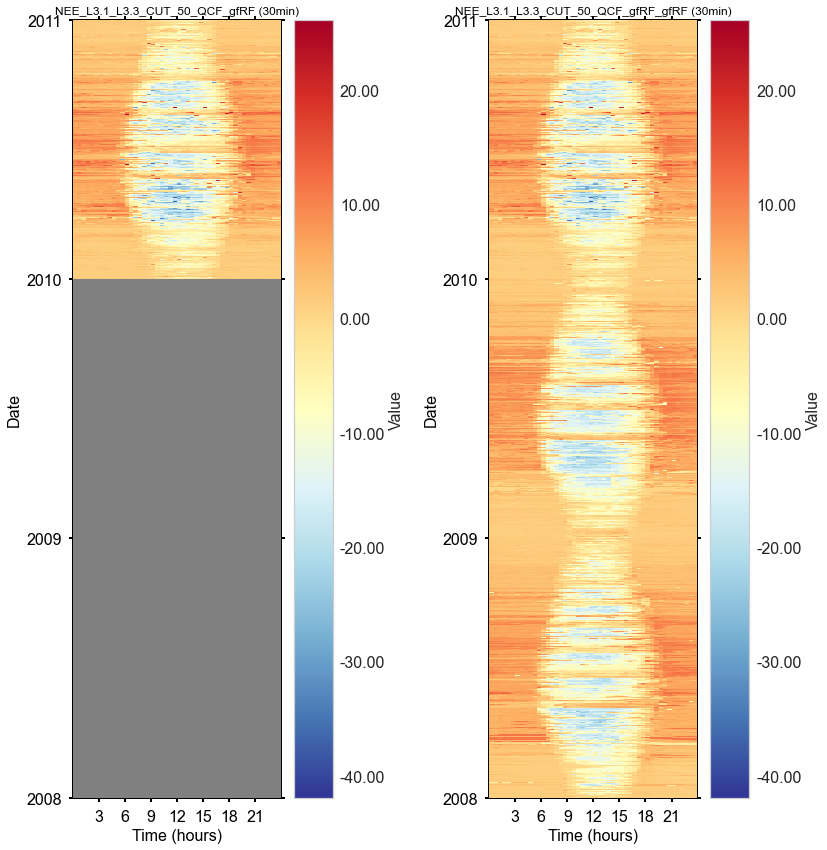

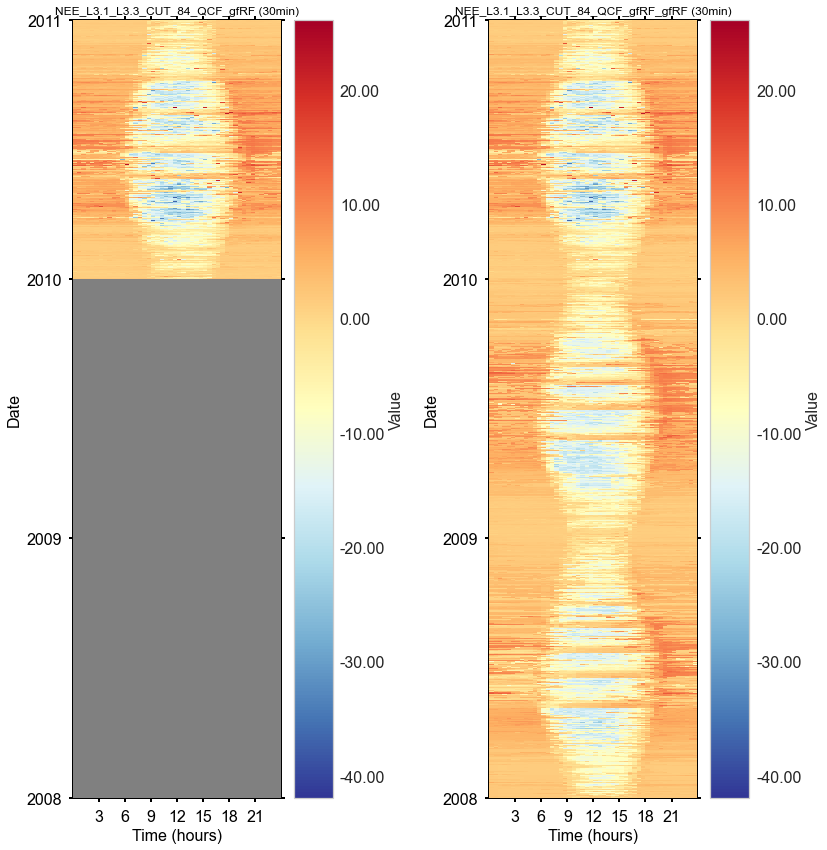

In [14]:
for target_col in fluxes_nee:

    # Make subset of required data    
    USECOLS = [target_col, SWIN_COL, TA_COL, VPD_COL]
    USECOLS = USECOLS + MGMT_VARS
    subset = df[USECOLS].copy()
    
    # Run random forest
    rfts = RandomForestTS(
        input_df=subset,
        target_col=target_col,
        **rf_settings)
    
    # rfts.reduce_features()
    # rfts.report_feature_reduction()
    rfts.trainmodel(showplot_scores=False, showplot_importance=False)
    # rfts.report_traintest()
    rfts.fillgaps(showplot_scores=False, showplot_importance=False)
    rfts.report_gapfilling()

    # Results
    res = rfts.gapfilling_df_

    # Results for relevant year(s)
    fluxname_filled = rfts.get_gapfilled_target().name
    flagname_filled = rfts.get_flag().name
    res_year = res[(res.index.year >= 2008) & (res.index.year <= 2009)].copy()
    res_year = res_year[[fluxname_filled, flagname_filled]].copy()   
    df = pd.concat([df, res_year], axis=1)
    
    # Heatmaps
    fig = plt.figure(facecolor='white', figsize=(10, 12), dpi=72)
    gs = gridspec.GridSpec(1, 2)  # rows, cols
    gs.update(wspace=0.6, hspace=0.1, left=0.03, right=0.97, top=0.95, bottom=0.05)
    ax1 = ax_series = fig.add_subplot(gs[0, 0])
    ax2 = ax_series = fig.add_subplot(gs[0, 1])
    HeatmapDateTime(series=res[target_col], ax=ax1).plot()
    HeatmapDateTime(series=res[fluxname_filled], ax=ax2).plot()  

In [18]:
fluxes_nee_filled = [f"{f}_gfRF" for f in fluxes_nee]
for f in fluxes_nee:
    df[f] = df[f].fillna(df[f"{f}_gfRF"])
    df[f] = df[f].fillna(df[f"{f}_gfRF"])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


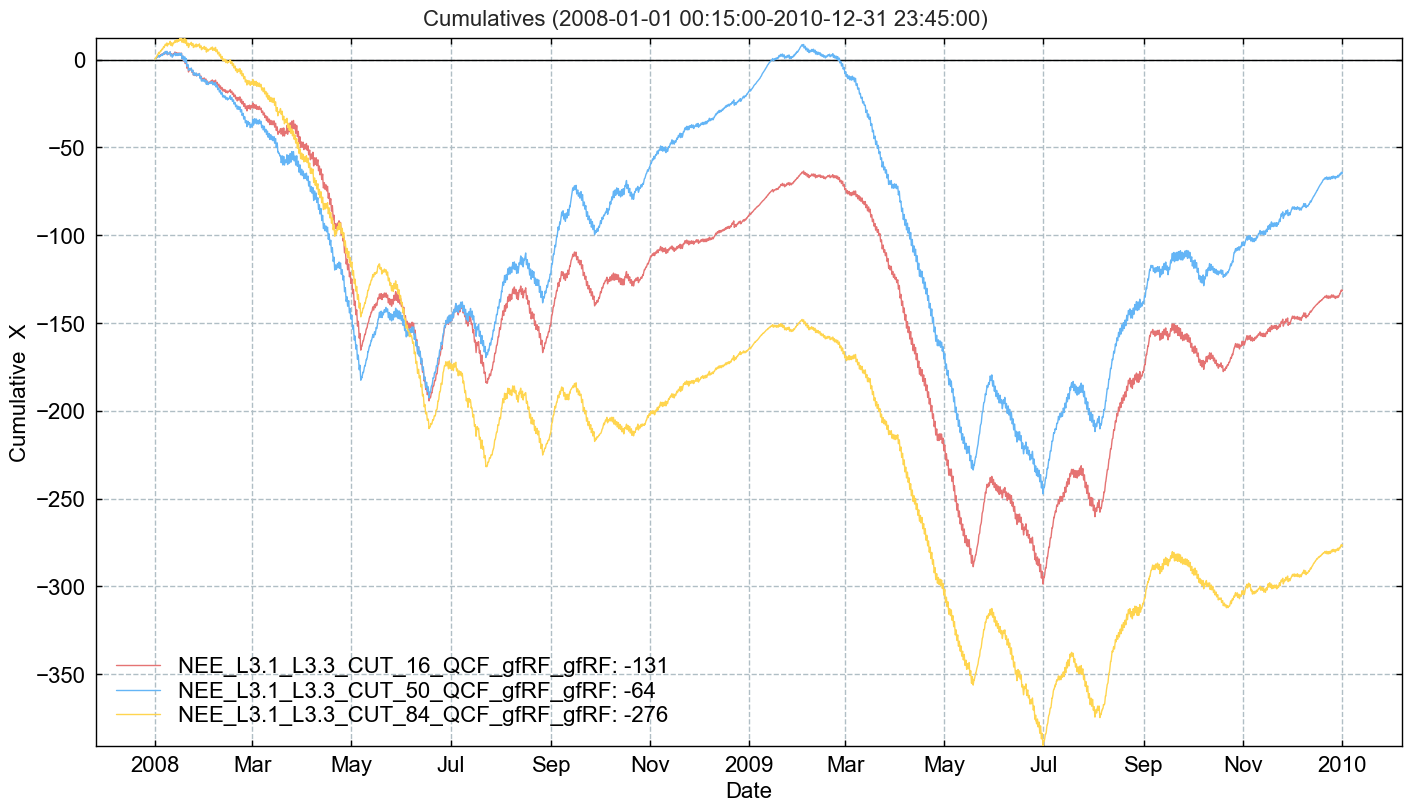

In [19]:
Cumulative(df=df[fluxes_nee_filled].multiply(0.02161926), units="X").plot()

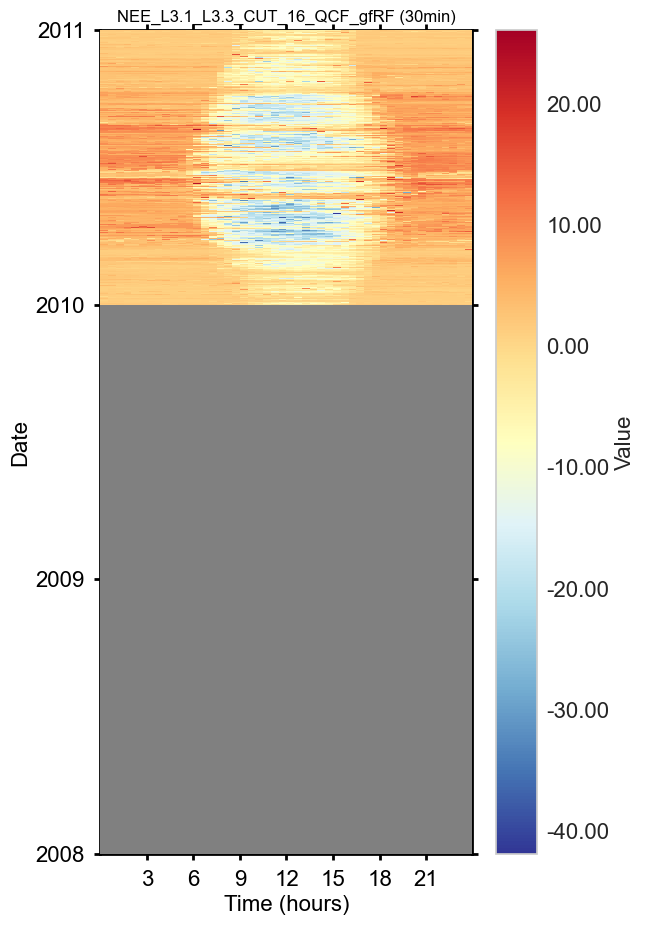

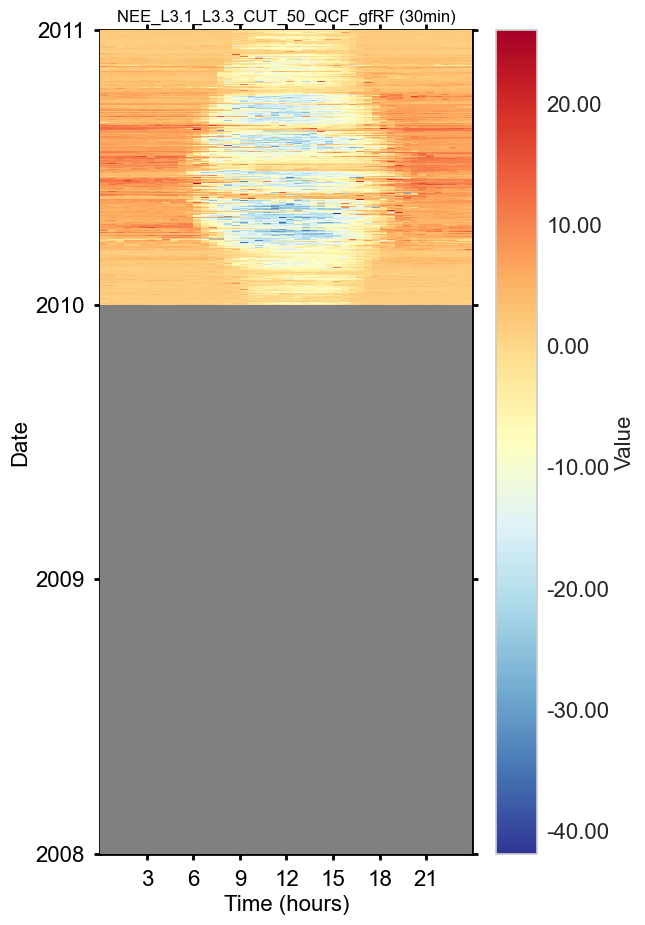

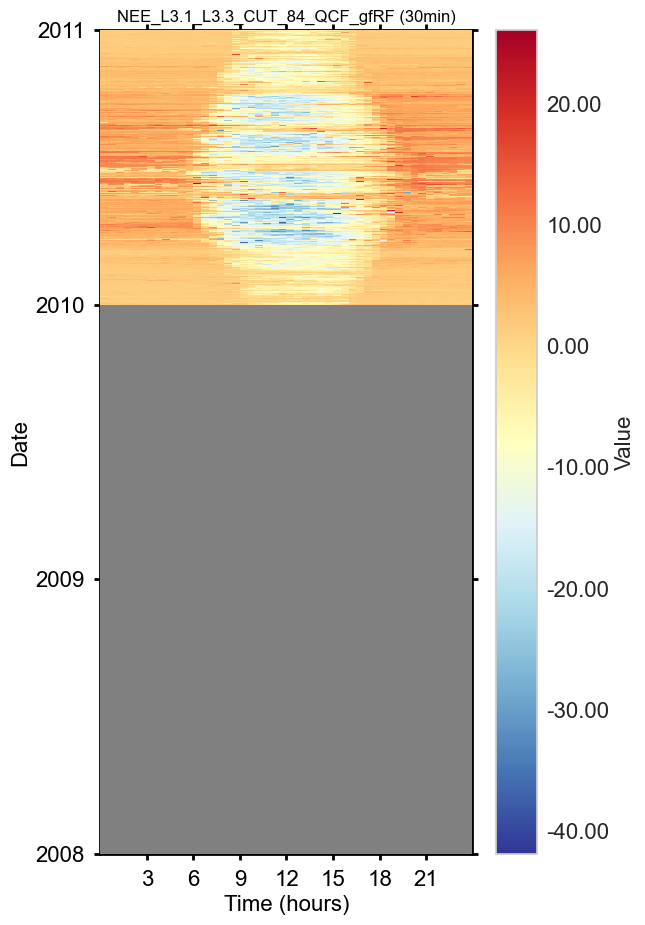

In [16]:
for f in fluxes_nee:
    HeatmapDateTime(series=df[f]).plot()